# Hypothesis: Linear regression coeficient of returns of two stocks can be used as hedge ratio for pairs trading

Here, we get a long term hedge ratio using daily returns of two stocks and apply it for short term pairs (minute level) trading 

In [10]:
import pandas as pd
import eikon as ek
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

ek.set_app_key('APP_KEY')


# DayTrade Function 
It trades for a day with a given slope as hedge ratio for two symbols between a given time and returns the cumulative returns at the end of the day


In [11]:

def DayTrade(sellsym, buysym,date,period,slope):
    
    stt_date = date + ' 3:46:00'
    end_date = date + ' 10:30:00'

    data = ek.get_timeseries(rics=[sellsym,buysym],fields=['CLOSE'],
                                start_date=stt_date,
                                end_date=end_date,
                                interval='minute',corax='adjusted')

    data_15 = pd.DataFrame(columns=data.columns)
    data_15[sellsym] = data.resample(period).ohlc()[sellsym,'close']
    data_15[buysym] = data.resample(period).ohlc()[buysym,'close']

    datarets = data_15 - data_15.shift(1)
    datarets.fillna(0)


    buy_timestamps = []
    sell_timestamps = []
    buyexit_timestamps = []
    sellexit_timestamps = []
    for i,row in datarets.iterrows():
        if(row[sellsym] > 0):
            if(row[buysym]/row[sellsym] < (slope-1) ):
                buy_timestamps.append(i)
            elif((row[buysym]/row[sellsym] > (slope-0.5) ) &(row[buysym]/row[sellsym] < (slope) ) ):
                buyexit_timestamps.append(i)

    for i,row in datarets.iterrows():
        if(row[sellsym] > 0):
            if(row[buysym]/row[sellsym] > (slope+1) ):
                sell_timestamps.append(i)
            elif((row[buysym]/row[sellsym] < (slope+0.5) )&(row[buysym]/row[sellsym] > (slope) ) ):
                sellexit_timestamps.append(i)
                
                
    buys = pd.DataFrame(index=buy_timestamps)
    buys['Buy'] = 1
    sells = pd.DataFrame(index=sell_timestamps)
    sells['Sell'] = -1
    buyexits = pd.DataFrame(index=buyexit_timestamps)
    buyexits['Buy'] = -1
    sellexits = pd.DataFrame(index=sellexit_timestamps)
    sellexits['Sell'] = 1

    #Because of mirror marking of Buy/Sell... assigning the opposite signs 
    Buys = (buys.append(buyexits))
    Sells = (sells.append(sellexits))
    
    
    
    data_15 = pd.concat([data_15.fillna(method='ffill'),Buys],axis=1,join='outer')
    data_15 = pd.concat([data_15.fillna(method='ffill'),Sells],axis=1,join='outer')

    data_15['Buy'][0] = 0
    data_15['Sell'][0] = 0

    data_15.Buy = data_15.Buy.fillna(method='pad')
    data_15.Sell = data_15.Sell.fillna(method='pad')


    data_15['Spread'] =   data_15[buysym] - data_15[sellsym]
    data_15['nUnits'] =   data_15.Buy + data_15.Sell
    data_15['nUnits'] =   data_15['nUnits'].apply(lambda x: min(max(x,-1),1)) * -1

    data_15['SpreadRets'] = (data_15.Spread - data_15.Spread.shift(1))/data_15.Spread.shift(1)
    data_15['port rets'] = data_15['SpreadRets'] * data_15['nUnits'].shift(0)
    data_15['cum rets'] = data_15['port rets'].cumsum() 

    return data_15['cum rets'].iloc[-1], data_15['cum rets'].min(),data_15['Spread'][0]


# Hedge Ratio Finder
Finds the daily regression coefficient for a given pair of stocks. Also it needs the samples to be taken as input from past to be considered in the regression. Final outcome of this cell is a table which returns linreg coef, score and SSE for the regression model for samples from that particular day

In [22]:

S1 = 'ICBK.NS'
S2 = 'AXBK.NS'

time_series = ek.get_timeseries(rics=[S1,S2],fields=['CLOSE'],
                            start_date='2020-08-01',
                            end_date='2020-09-10',
                            interval='daily',corax='adjusted')

returns = (time_series  - time_series.shift(1))/time_series.shift(1)
returns = returns.fillna(0)

returns['Coef'] = 0.0
Samples_Taken = 10
returns['score'] = 0.0
returns['SSE'] = 0.0

for i in range(Samples_Taken,len(returns)):
    X = returns[S1][i-Samples_Taken:i].values.reshape(-1,1)
    y = returns[S2][i-Samples_Taken:i].values.reshape(-1,1)
    huber = HuberRegressor()
    huber.fit(X, y)
    returns['Coef'][i] = huber.coef_
    returns['score'][i] = huber.score(X, y)
    returns['SSE'][i] = metrics.mean_squared_error(X, y)
    
returns = returns[Samples_Taken:]

# Backtest on multiple days

These lines get the daily returns dataframe and run the DayTrade function on each line and pushes the P&L report to an output file

In [ ]:
import time

returns['daytraderets'] = 0.000 
returns['maxdrawdown'] = 0.000 
returns['SpreadOpen'] = 0.000 


for i,row in returns.iterrows():
    try:
        returns.loc[i,'daytraderets'],returns.loc[i,'maxdrawdown'],returns.loc[i,'SpreadOpen'] = DayTrade('ICBK.NS','AXBK.NS',str(i),'10min',row['Coef'])
    except:
        row['daytraderets'],row['maxdrawdown'],returns['SpreadOpen'] = 0.00 , 0.00 ,0.00
    
    returns.to_csv('NewDayTrade.csv')
    print(i)
    time.sleep(2)


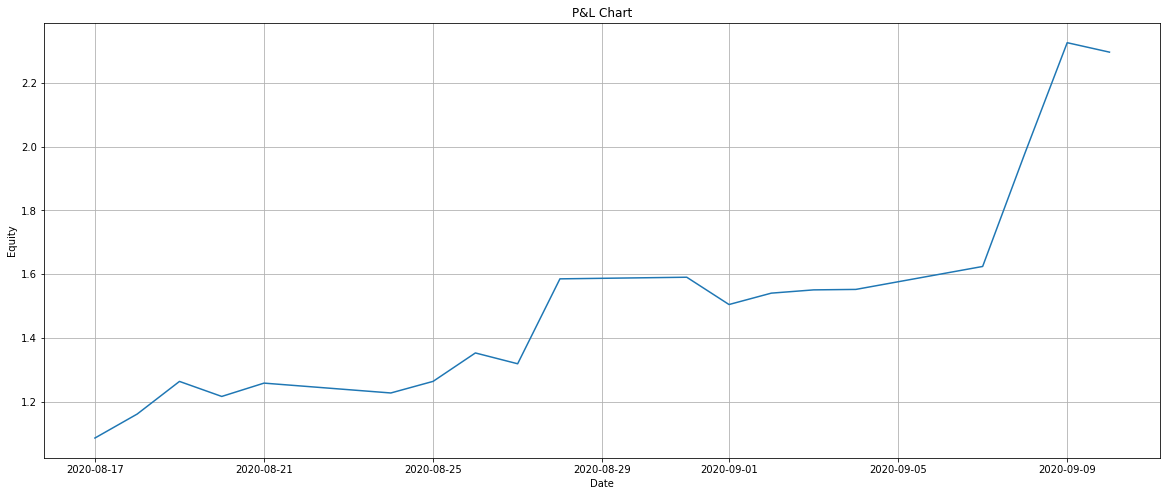

In [31]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
plt.grid()
plt.xlabel("Date")
plt.ylabel("Equity")
plt.title("P&L Chart")

plt.plot((1+returns['daytraderets']).cumprod())